# Evaluating Home Field Advantage During the 2018 Regular Season

## Import packages and config

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import mysql.connector
import config
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.stats.power import TTestIndPower, TTestPower

## Connect to database

In [2]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.password,
    database = 'sports'
)
cursor = cnx.cursor(buffered=True)

## Define Functions

In [3]:
# Creates the 'home_pt_diff' column
def home_pt_diff(df):
    df['home_pt_diff'] = df['home_team_score'] - df['away_team_score']
    return df['home_pt_diff']



# Returns a list of the actual data in the df. Suggestion: pass through only one column
def get_Actuals(df):
    actuals = [df.iloc[i] for i in range(df.shape[0])]
    return actuals



# Returns a list of z-scores of the actual data in df. Suggestion: pass through only one column
def get_Zscores(df):
    mu = df.mean()
    sigma = df.std()
    z_scores = [(df.iloc[i]-mu)/sigma for i in range(df.shape[0])]
    return z_scores



# Runs a one-sample t-test on data. Population_mean = mu and alpha = a
def run_ttest(data, mu, alpha):
    
    #calculate parameters
    n = len(data)
    s = np.std(data)
    x_bar = np.mean(data)
    std_err = s/np.sqrt(n)
    t_crit = stats.t.ppf(1-alpha, df=n-1)
    
    #calculate the t-value and p-value
    t_p_values = stats.ttest_1samp(a=data, popmean=mu)
    t = t_p_values[0]
    p = t_p_values[1]
    
    #print results of test
    if (t>t_crit) and (p<alpha):
        print(f'Null hypothesis rejected. Results are statistically significant since t-value: {round(t,3)} > critical t-value: {round(t_crit,3)} and p-value: {p} < alpha: {alpha}\n')
    else:
        print(f'Null hypothesis not rejected. Results are not statistically significant with t-value: {round(t,3)} < critical t-value: {round(t_crit,3)} and p-value: {p} > alpha: {alpha}\n')


        
# Creates a conditional column "timing". A 0 indicates early in the season and a 1 indicates late in the season
def time_of_season(df, timing_list):
    df['timing'] = 0
    for i in range(df.shape[0]):
        if df['month'].iloc[i] in timing_list:
            df['timing'].iloc[i] = 0
        else:
            df['timing'].iloc[i] = 1

            
            
# Creates a new dataframe based on home team winning and timing of the game in the season (early or late)
# Used in calculating conditional probabilities
def create_HTW_timing_df(df, timing):
    new_df = df[(df['home_pt_diff']>0) & (df['timing'] == timing)]
    return new_df
        
    
    
# Generates a new dataframe based soley on timing of the game (early or late)    
def create_timing_df(df, timing):
    new_df = df[df['timing'] == timing]
    return new_df



# Calculates Cohen's D. Suggestion: only pass lists in as data1 and data2
def Cohen_d(data1, data2):
    
    #calculate parameters
    xbar_1, xbar_2 = np.mean(data1), np.mean(data2)
    var_1, var_2 = np.var(data1), np.var(data2)
    n1, n2 = len(data1), len(data2)
    var_p = ((n1-1)*var_1 + (n2-1)*var_2) / (n1+n2-2)
    
    #calculate Cohen's D
    d = (xbar_1 - xbar_2) / np.sqrt(var_p)
    return d



# Runs a two-sample t-test on df_early, df_late, and alpha = a.
# Returns results of t-test, t-value, critical t-value, and p-value
def run_2ttest(data1, data2, alpha):
    
    #calculate parameters
    xbar_1, xbar_2 = np.mean(data1), np.mean(data2)
    var_1, var_2 = np.var(data1), np.var(data2)
    n1, n2 = len(data1), len(data2)
    var_p = ((n1-1)*var_1 + (n2-1)*var_2) / (n1+n2-2)
    ddof = (n1+n2-2)
    t_crit = stats.t.ppf(1-(alpha/2),df=ddof)
    
    #calculate t-value and p-value
    t = abs(xbar_1 - xbar_2) / np.sqrt(var_p*((1/n1) + (1/n2)))
    lower_tail = stats.t.cdf(-t, ddof, 0, 1)
    upper_tail = 1-stats.t.cdf(t, ddof, 0, 1)
    p = lower_tail + upper_tail

    #calculate power
    effect_size = Cohen_d(data1, data2)
    power_analysis = TTestIndPower()
    power = power_analysis.solve_power(effect_size=effect_size, nobs1=(n1+n2)//2, alpha=alpha)
                                       
    #print results of test
    if (t>t_crit) and (p<alpha):
        print(f'Null hypothesis rejected. Results are statistically significant since t-value: {round(t,3)} > critical t-value: {round(t_crit,3)} and p-value: {p} < alpha: {alpha}')
        print(f' Power: {power}')
    else:
        print(f'Null hypothesis not rejected. Results are not statistically significant with t-value: {round(t,3)} < critical t-value: {round(t_crit,3)} and p-value: {p} > alpha: {alpha}')
        print(f' Power: {power}')    
    print(f'  Sample mean difference is {round((xbar_1-xbar_2),3)}\n')

## Query MySQL for data and create dataframes

In [5]:
#football
cursor.execute("""
SELECT
    game_id,
    month,
    away_team,
    away_team_score,
    home_team,
    home_team_score
FROM
    sports.nfl
;
""")

nfl_data = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
]

nfl_df = pd.DataFrame(nfl_data,columns=columns).set_index('game_id')


nfl_df['home_pt_diff'] = 0 # create dummy values for a new column
nfl_df['home_pt_diff'] = nfl_df.apply(home_pt_diff, axis=1) #apply the home_pt_function to the new column

#hockey
cursor.execute("""
SELECT
    game_id,
    month,
    away_team,
    away_team_score,
    home_team,
    home_team_score
FROM
    sports.nhl
;
""")

nhl_data = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
]

nhl_df = pd.DataFrame(nhl_data,columns=columns).set_index('game_id')
nhl_df['home_pt_diff'] = 0
nhl_df['home_pt_diff'] = nhl_df.apply(home_pt_diff, axis=1)

#baseball
cursor.execute("""
SELECT
    game_id,
    month,
    away_team,
    away_team_score,
    home_team,
    home_team_score
FROM
    sports.mlb
;
""")

mlb_data = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
]

mlb_df = pd.DataFrame(mlb_data,columns=columns).set_index('game_id')
mlb_df['home_pt_diff'] = 0
mlb_df['home_pt_diff'] = mlb_df.apply(home_pt_diff, axis=1)

#basketball
cursor.execute("""
SELECT
    *
FROM
    sports.nba
WHERE
    (month > 10 and month <= 12) OR (month >= 01 and month < 04)
;
""")

nba_data = cursor.fetchall()

columns = [
    'game_id',
    'month',
    'away_team',
    'away_team_score',
    'home_team',
    'home_team_score',
]

nba_df = pd.DataFrame(nba_data,columns=columns).set_index('game_id')
nba_df['home_pt_diff'] = 0
nba_df['home_pt_diff'] = nba_df.apply(home_pt_diff, axis=1)

Get a list of actual and standarized home team point differential data. Uses formula defined above.

In [6]:
#football
nfl_actuals = get_Actuals(nfl_df['home_pt_diff'])
nfl_zscores = get_Zscores(nfl_df['home_pt_diff'])

#hockey
nhl_actuals = get_Actuals(nhl_df['home_pt_diff'])
nhl_zscores = get_Zscores(nhl_df['home_pt_diff'])

#baseball
mlb_actuals = get_Actuals(mlb_df['home_pt_diff'])
mlb_zscores = get_Zscores(mlb_df['home_pt_diff'])

#basketball
nba_actuals = get_Actuals(nba_df['home_pt_diff'])
nba_zscores = get_Zscores(nba_df['home_pt_diff'])

## Generate Graphs

#### Graph 1: FOR INTERNAL USE ONLY. Purpose is to visiualize our data accross sports

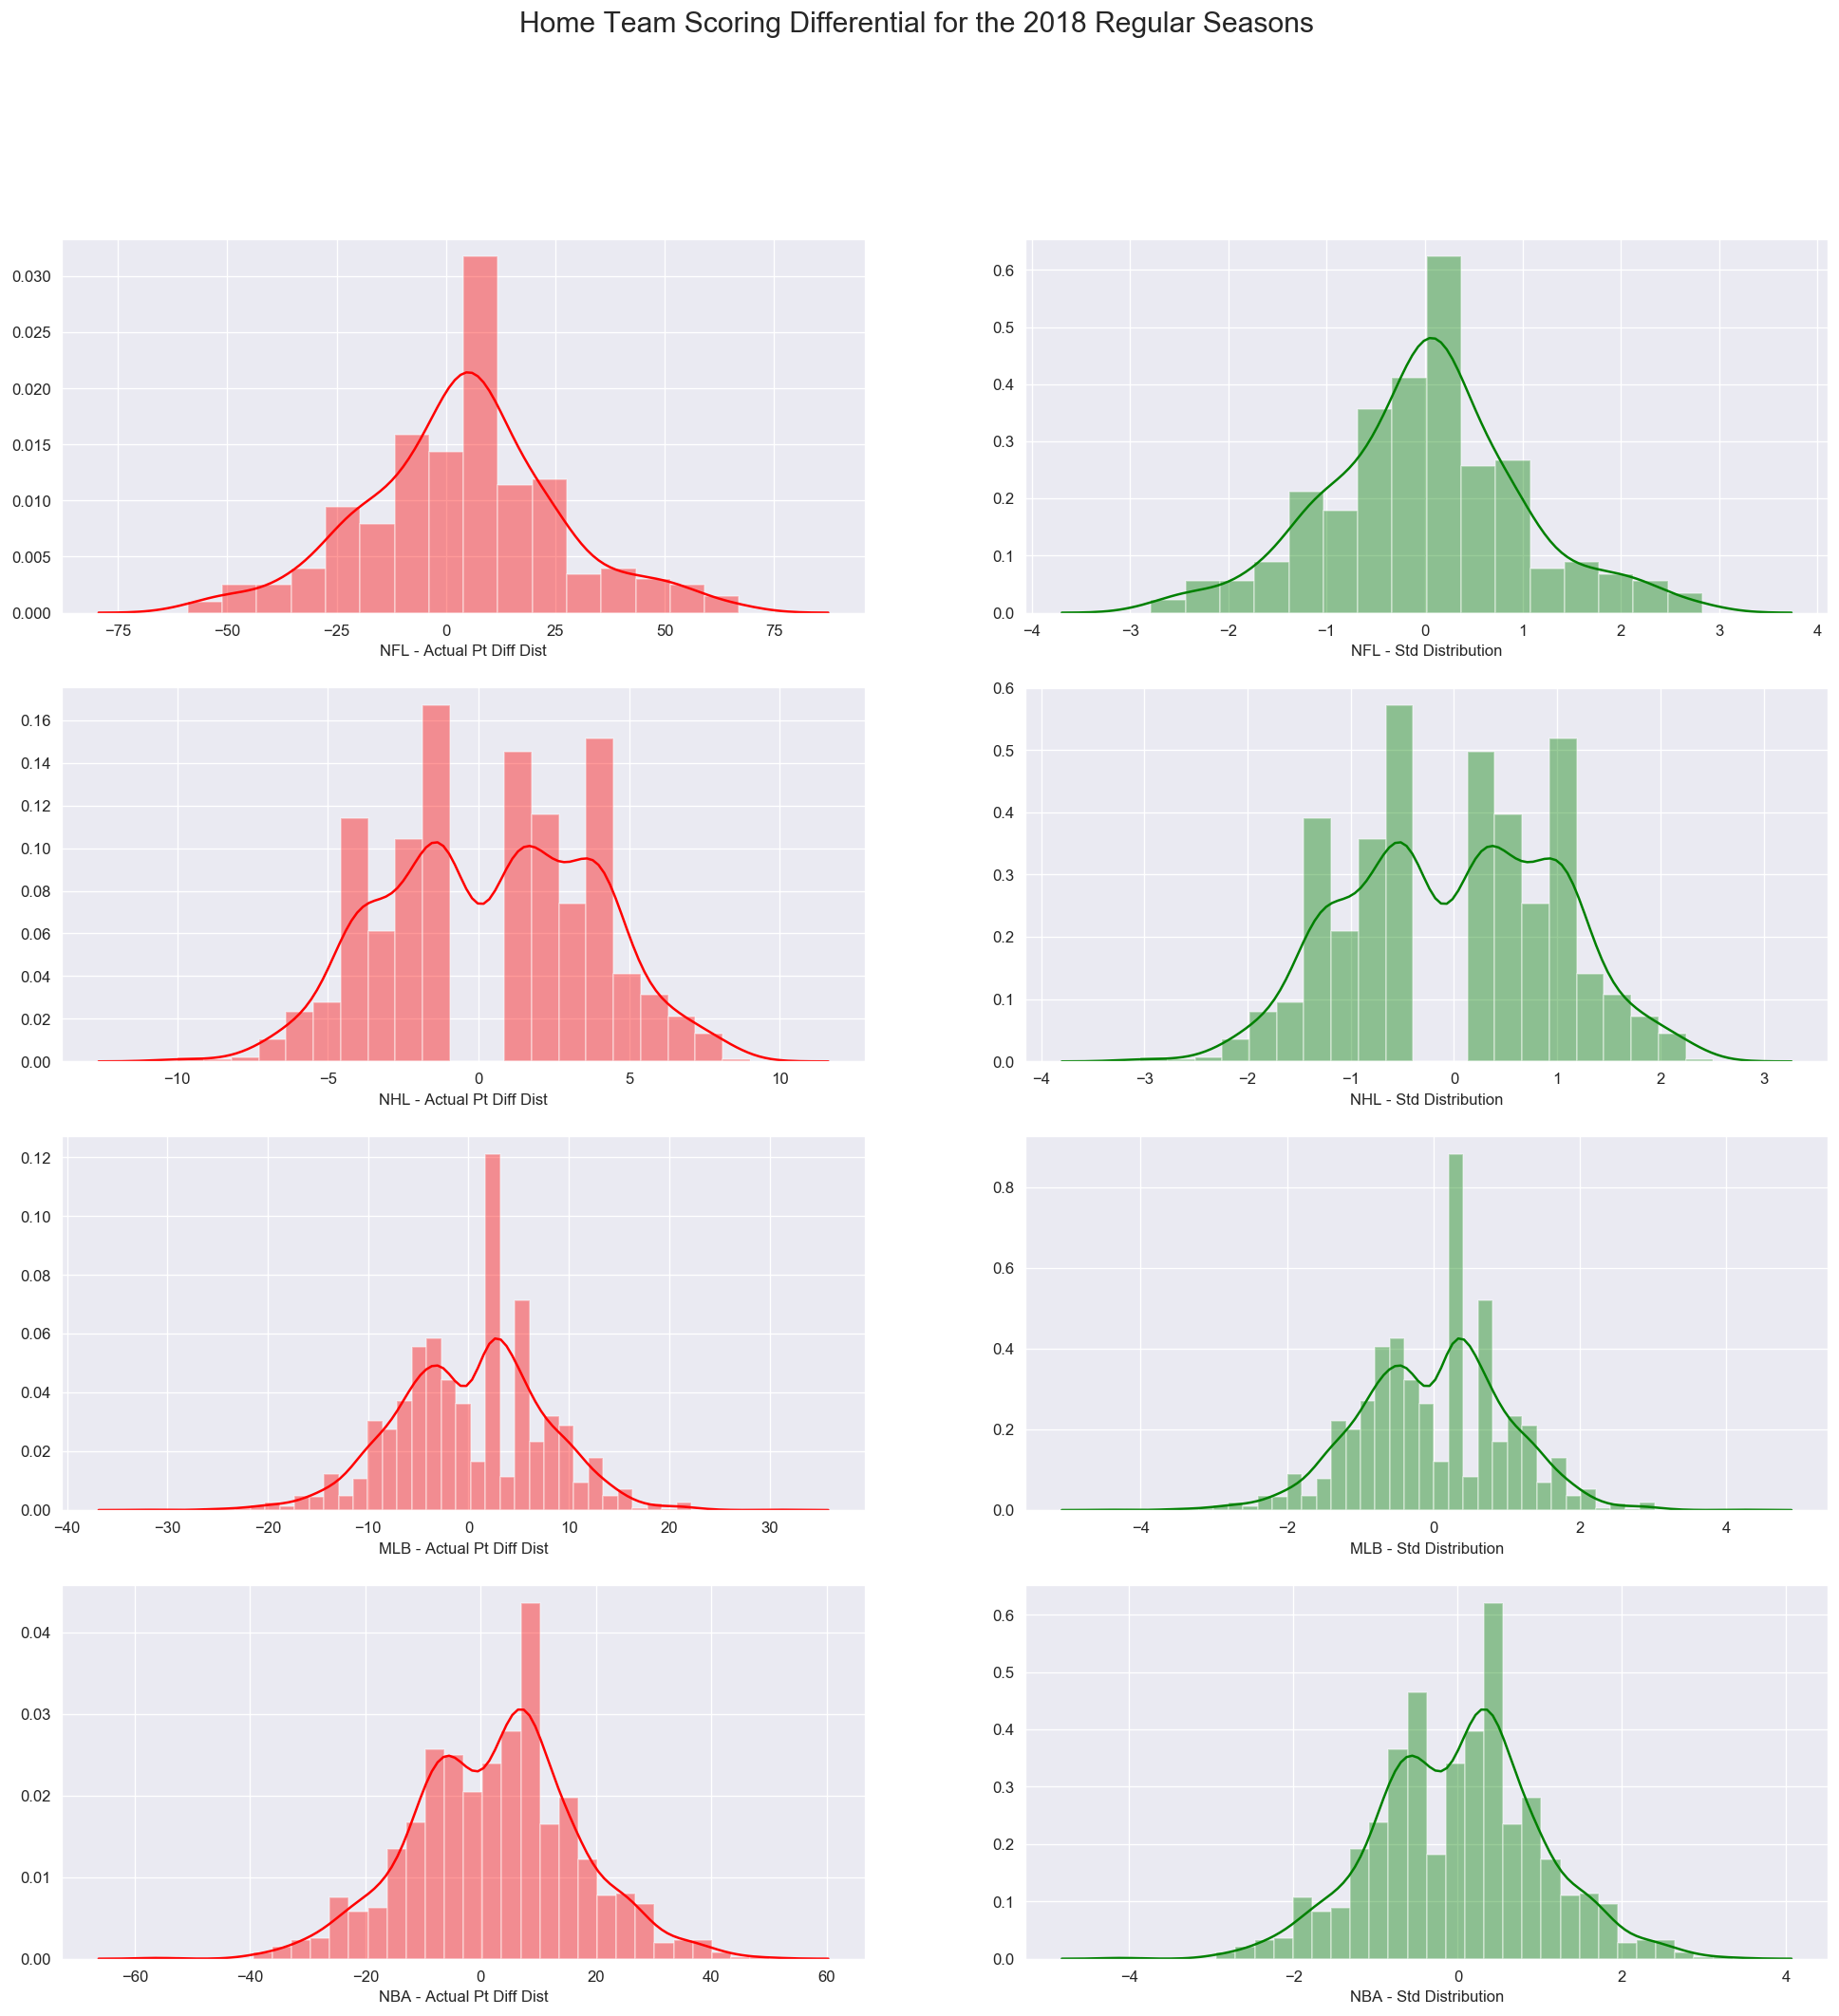

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20), sharex=False, sharey=False, dpi=120)
fig.suptitle('Home Team Scoring Differential for the 2018 Regular Seasons', fontsize=18)

#football: actual / standard
sns.distplot(nfl_actuals,
             bins='auto',
             color='r',
             ax=axes[0][0],
             axlabel = 'NFL - Actual Pt Diff Dist'
            );

sns.distplot(nfl_zscores,
             bins='auto',
             color='g',
             ax=axes[0][1],
             axlabel = 'NFL - Std Distribution'
            );

#hockey: actual / standard
sns.distplot(nhl_actuals,
             bins='auto',
             color='r',
             ax=axes[1][0],
             axlabel = 'NHL - Actual Pt Diff Dist'
            );

sns.distplot(nhl_zscores,
             bins='auto',
             color='g',
             ax=axes[1][1],
             axlabel = 'NHL - Std Distribution'
            );

#baseball: actual / standard
sns.distplot(mlb_actuals,
             bins='auto',
             color='r',
             ax=axes[2][0],
             axlabel = 'MLB - Actual Pt Diff Dist'
            );

sns.distplot(mlb_zscores,
             bins='auto',
             color='g',
             ax=axes[2][1],
             axlabel = 'MLB - Std Distribution'
            );

#basketball: actual / standard
sns.distplot(nba_actuals,
             bins='auto',
             color='r',
             ax=axes[3][0],
             axlabel = 'NBA - Actual Pt Diff Dist'
            );

sns.distplot(nba_zscores,
             bins='auto',
             color='g',
             ax=axes[3][1],
             axlabel = 'NBA - Std Distribution'
            );

#### Graph 2: Boxplot of the home team point differential

In [8]:
# create a list of dictionaries for the sports data
sports_dict = [
    {'sample' : 'Football',
     'data' : nfl_actuals
    },
    {'sample' : 'Hockey',
     'data' : nhl_actuals
    },
    {'sample' : 'Baseball',
     'data' : mlb_actuals
    },
    {'sample' : 'Basketball',
     'data' : nba_actuals
    }
]

#create a list of x values and y values for boxplot
boxplot_x = []
boxplot_y = []
for sport in sports_dict:
    for i in range(len(sport['data'])):
        boxplot_x.append(sport['sample'])
        boxplot_y.append(sport['data'][i])

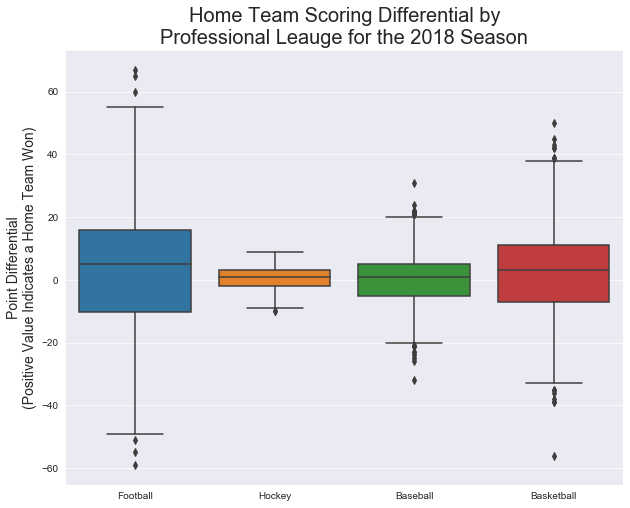

In [9]:
fig2 = plt.figure(figsize=(10,8))
ax2 = fig2.add_subplot(111)
sns.boxplot(x=boxplot_x, y=boxplot_y, ax=ax2);
ax2.set_title('Home Team Scoring Differential by\nProfessional Leauge for the 2018 Season', {'fontsize' : 20});
ax2.set_ylabel('Point Differential\n(Positive Value Indicates a Home Team Won)', {'fontsize' : 14});

# Question 1: Is there home field advantage in any of the four major sports?

## To answer this question, we performed a 4 separate one-sample t-tests using the following null and alternative hypotheses:

$H_0: \mu_{sport}$  is ≤ 0

$H_1: \mu_{sport}$  is > 0 ; where $\mu_{sport}$ = the home team point differential population mean for each $s \in S$

1. Run t-tests to test alternative hypothesis.

In [10]:
#football
print('NFL:')
run_ttest(nfl_actuals, 0, 0.05)

#football
print('NHL:')
run_ttest(nhl_actuals, 0, 0.05)

#football
print('MLB:')
run_ttest(mlb_actuals, 0, 0.05)

#football
print('NBA:')
run_ttest(nba_actuals, 0, 0.05)

NFL:
Null hypothesis rejected. Results are statistically significant since t-value: 2.519 > critical t-value: 1.651 and p-value: 0.012378282339276653 < alpha: 0.05

NHL:
Null hypothesis rejected. Results are statistically significant since t-value: 4.218 > critical t-value: 1.646 and p-value: 2.637527049534951e-05 < alpha: 0.05

MLB:
Null hypothesis not rejected. Results are not statistically significant with t-value: 1.102 < critical t-value: 1.645 and p-value: 0.27075858563627736 > alpha: 0.05

NBA:
Null hypothesis rejected. Results are statistically significant since t-value: 5.822 > critical t-value: 1.646 and p-value: 7.432557876116745e-09 < alpha: 0.05



## The Results

Using the 2018 regular season as a sample for all games played in league history, there exists stastical evidence of home field advantage in three of the four major professional sport leagues (Football, Hockey, and Basketball), while there exists no statistical evidence of a home field advantage in Baseball.

# Question 2: Is there an advantage to playing at home earlier in the season as compared to later in the season 

## To answer this question, we performed a 4 separate two-sample t-tests using the following null and alternative hypotheses:

$H_0: \bar x_{early} = \bar x_{late}$

$H_1: \bar x_{early} ≠ \bar x_{late}$ ; where

$\bar x_{early}$ = avg. home team point differential for early season games & $\bar x_{late}$ = avg. home team point differential for late season games

#### Steps performed:

1. Generate timing list of "early season months". If month is not in list, it is considered a "late season month"

In [11]:
#football
nfl_timing = ['09','10']

#hockey
nhl_timing = ['10', '11', '12']

#baseball
mlb_timing = ['03','04','05']

#basketball
nba_timing = ['11','12']

2. Expand dataframe to include conditional column "timing" where 1 = late in the season and 0 = early in the season. Uses formula defined above

In [13]:
#football
time_of_season(nfl_df, nfl_timing)

#hockey
time_of_season(nhl_df, nhl_timing)

#baseball
time_of_season(mlb_df, mlb_timing)

#basketball
time_of_season(nba_df, nba_timing)

3. Create new dataframs including only games where timing was "early" or "late" (timing = 0 or 1). Uses formula defined above

In [14]:
#football
nfl_df_early = create_timing_df(nfl_df, 0)
nfl_df_late = create_timing_df(nfl_df, 1)

#hockey
nhl_df_early = create_timing_df(nhl_df, 0)
nhl_df_late = create_timing_df(nhl_df, 1)

#baseball
mlb_df_early = create_timing_df(mlb_df, 0)
mlb_df_late = create_timing_df(mlb_df, 1)

#basketball
nba_df_early = create_timing_df(nba_df, 0)
nba_df_late = create_timing_df(nba_df, 1)

4. Get a list of "early" and "late" home team point differentials. Uses formula defined above

In [15]:
#football
nfl_df_late_actuals = get_Actuals(nfl_df_late['home_pt_diff'])
nfl_df_early_actuals = get_Actuals(nfl_df_early['home_pt_diff'])

#hockey
nhl_df_late_actuals = get_Actuals(nhl_df_late['home_pt_diff'])
nhl_df_early_actuals = get_Actuals(nhl_df_early['home_pt_diff'])

#baseball
mlb_df_late_actuals = get_Actuals(mlb_df_late['home_pt_diff'])
mlb_df_early_actuals = get_Actuals(mlb_df_early['home_pt_diff'])

#basketball
nba_df_late_actuals = get_Actuals(nba_df_late['home_pt_diff'])
nba_df_early_actuals = get_Actuals(nba_df_early['home_pt_diff'])

5. Run t-tests to test alternative hypothesis

In [16]:
#football
print("NFL:")
run_2ttest(nfl_df_late_actuals, nfl_df_early_actuals, 0.05)

#hockey
print("NHL:")
run_2ttest(nhl_df_late_actuals, nhl_df_early_actuals, 0.05)

#baseball
print("MLB:")
run_2ttest(mlb_df_late_actuals, mlb_df_early_actuals, 0.05)

#basketball
print("NBA:")
run_2ttest(nba_df_late_actuals, nba_df_early_actuals, 0.05)

NFL:
Null hypothesis not rejected. Results are not statistically significant with t-value: 0.013 < critical t-value: 1.969 and p-value: 0.9898310731445188 > alpha: 0.05
 Power: 0.050018559448440594
  Sample mean difference is 0.036

NHL:
Null hypothesis not rejected. Results are not statistically significant with t-value: 0.269 < critical t-value: 1.962 and p-value: 0.7876555124137834 > alpha: 0.05
 Power: 0.058348889708186476
  Sample mean difference is -0.052

MLB:
Null hypothesis not rejected. Results are not statistically significant with t-value: 0.222 < critical t-value: 1.961 and p-value: 0.8243216849648041 > alpha: 0.05
 Power: 0.05618626931616508
  Sample mean difference is 0.068

NBA:
Null hypothesis not rejected. Results are not statistically significant with t-value: 0.923 < critical t-value: 1.962 and p-value: 0.35640823131743465 > alpha: 0.05
 Power: 0.16004039156570127
  Sample mean difference is -0.784



#### Additional analysis - calculated conditional probabilities. Example "what is the probability of winning at home given the game is played late (or early) in the season"

1. Create new dataframes including only games where home team point differential was positive and timing was "early" or "late" (timing = 0 or 1). Uses formula defined above

In [17]:
#football
nfl_df_HTW_early = create_HTW_timing_df(nfl_df, 0)
nfl_df_HTW_late = create_HTW_timing_df(nfl_df, 1)

#Hockey
nhl_df_HTW_early = create_HTW_timing_df(nhl_df, 0)
nhl_df_HTW_late = create_HTW_timing_df(nhl_df, 1)

#Baseball
mlb_df_HTW_early = create_HTW_timing_df(mlb_df, 0)
mlb_df_HTW_late = create_HTW_timing_df(mlb_df, 1)

#Basketball
nba_df_HTW_early = create_HTW_timing_df(nba_df, 0)
nba_df_HTW_late = create_HTW_timing_df(nba_df, 1)

2. Calculate conditional probabilities

In [18]:
#football
nfl_prob_HTW_given_E = nfl_df_HTW_early.shape[0]/nfl_df_early.shape[0]
nfl_prob_HTW_given_L = nfl_df_HTW_late.shape[0]/nfl_df_late.shape[0]
print(f"NFL:")
print(f" Probability of winning at home early in the season: {round(nfl_prob_HTW_given_E*100,2)}%")
print(f" Probability of winning at home late in the season: {round(nfl_prob_HTW_given_L*100,2)}%\n")

#hockey
nhl_prob_HTW_given_E = nhl_df_HTW_early.shape[0]/nhl_df_early.shape[0]
nhl_prob_HTW_given_L = nhl_df_HTW_late.shape[0]/nhl_df_late.shape[0]
print(f"NHL:")
print(f" Probability of winning at home early in the season: {round(nhl_prob_HTW_given_E*100,2)}%")
print(f" Probability of winning at home late in the season: {round(nhl_prob_HTW_given_L*100,2)}%\n")

#baseball
mlb_prob_HTW_given_E = mlb_df_HTW_early.shape[0]/mlb_df_early.shape[0]
mlb_prob_HTW_given_L = mlb_df_HTW_late.shape[0]/mlb_df_late.shape[0]
print(f"MLB:")
print(f" Probability of winning at home early in the season: {round(mlb_prob_HTW_given_E*100,2)}%")
print(f" Probability of winning at home late in the season: {round(mlb_prob_HTW_given_L*100,2)}%\n")

#basketball
nba_prob_HTW_given_E = nba_df_HTW_early.shape[0]/nba_df_early.shape[0]
nba_prob_HTW_given_L = nba_df_HTW_late.shape[0]/nba_df_late.shape[0]
print(f"NBA:")
print(f" Probability of winning at home early in the season: {round(nba_prob_HTW_given_E*100,2)}%")
print(f" Probability of winning at home late in the season: {round(nba_prob_HTW_given_L*100,2)}%\n")

NFL:
 Probability of winning at home early in the season: 61.16%
 Probability of winning at home late in the season: 59.26%

NHL:
 Probability of winning at home early in the season: 53.68%
 Probability of winning at home late in the season: 53.64%

MLB:
 Probability of winning at home early in the season: 50.74%
 Probability of winning at home late in the season: 51.41%

NBA:
 Probability of winning at home early in the season: 60.36%
 Probability of winning at home late in the season: 56.09%



## The Results

The conditional probabilities suggest that in the NFL you're more likely to win earlier in the season, in the NHL there is no increased/decreased likelyhood, in the MLB, there is slight home field advantage towards the end of the season, and in the NBA you're more likely to win at home late in the season.

However, there appears no statistical evidence to claim that the degree of home field advantage changes throughout the season.

# Question 3: 

# In Summary

#### END - CLOSE CURSOR & CONNECTION

In [ ]:
cursor.close()
cnx.close()